# Logistic Regression

### Testing out the results of logistic regression on just stock market data

The idea is to transform the stock market data into a series of binary classification tasks. I will be testing a few different tagets:

- single day prediction
- single week
- test a differenced data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# import the data
filepath='../../data/SPY_1993-01-29_2022-08-17.csv'
data = pd.read_csv(filepath)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.438103,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619028,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673309,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944679,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053232,531500


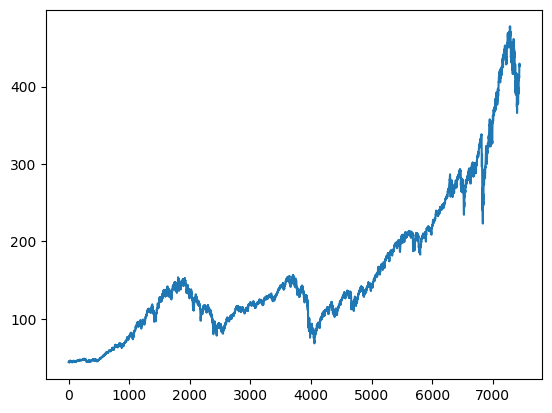

In [3]:
sns.lineplot(data=data['Close'].values);

In [4]:
# Creating single day labels
diff_df = data['Close'].diff()
diff_df.index = pd.to_datetime(data['Date'])
diff_df.head()

Date
1993-01-29        NaN
1993-02-01    0.31250
1993-02-02    0.09375
1993-02-03    0.46875
1993-02-04    0.18750
Name: Close, dtype: float64

In [21]:
labels = diff_df > 0
labels.tail()

Date
2022-08-11    False
2022-08-12     True
2022-08-15     True
2022-08-16     True
2022-08-17    False
Name: Close, dtype: bool

In [22]:
# shift the labels to fit the correct index
labels = labels.shift(periods=-1)

# drop the remaining NaN
labels = labels.dropna().astype(float)

In [23]:
labels.tail()

Date
2022-08-10    0.0
2022-08-11    1.0
2022-08-12    1.0
2022-08-15    1.0
2022-08-16    0.0
Name: Close, dtype: float64

In [24]:
# method to split the sequences into smaller portions for regression
def split_sequences(sequence, window_size):
    X = []
    for i in range(len(sequence)):
        end_ix = i + window_size
        if end_ix > len(sequence) - 1:
            break
        seq = sequence[i:end_ix]
        X.append(seq)
    return np.array(X)

In [34]:
from sklearn.model_selection import train_test_split

window_size = 5
X = split_sequences(data['Close'], window_size=window_size)
X = X[:-1]
y = labels[5:]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=42)

In [35]:
print(len(X_train), len(y_train))

5577 5577


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.5228617536309844


In [38]:
# using regular numbers did not work, going to normalize the inputs
percents = data['Close'].pct_change(periods=1)
percents.head()

0         NaN
1    0.007112
2    0.002119
3    0.010571
4    0.004184
Name: Close, dtype: float64

In [41]:
window_size = 5
X = split_sequences(percents, window_size=window_size)
X = X[1:-1]
y = labels[6:]

X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=42)

In [42]:
print(len(X), len(y))

7435 7435


In [43]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.5309306078536847


Still not great, doing some model tuning

In [45]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C':[.001, .01, .1, 1, 10, 100]}

clf = LogisticRegression()
selector = RandomizedSearchCV(estimator=clf, param_distributions=params)

result = selector.fit(X_train, y_train)
print('Best: %f using %s' % (result.best_score_, result.best_params_))
best_model = result.best_estimator_
print(accuracy_score(best_model.predict(X_test), y_test))

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best: 0.535868 using {'C': 0.001}
0.5309306078536847
